# AxiScan Example

Here we show an example of the AxiScan analysis pipeline.

## Import Code and Setup Plotting Defaults

In [2]:
# Import basics
import numpy as np
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import pymultinest
import corner

# Plotting Settings
mpl.rcParams['figure.figsize'] = 20, 14 # default figure size
%matplotlib inline
%load_ext autoreload
%autoreload 2


# Import MC generation and data analysis code The necessary modules
from AxiScan import mc_gen # MC Generation
from AxiScan import scan # Data Analysis
import analysis_utilities as au # Convenient Utility Methods

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Step 1: Generate Monte Carlo

## Set the Parameters

First we generate Monte Carlo data for a scenario in which the majority of the dark matter is contained within a bulk halo following the Standard Halo Model parameters with a subdominant fraction contained within the Sagitarrius Stream. Although we have chosen to illustrate the analysis with a large signal strength, this can be easily adjusted. 

This is accomplished by seeding an instance (`generator`) of the Generator class in `mc_gen` with arguments detailed below. Data on the $i^\text{th}$ day of data collection is generated by calling `generator.makePSD(i)`. The arguments for the Generator class are 

| Argument | Purpose |
| ------------- | ------------- |
| ma | ma/2pi is the axion mass [Hz] |
| A | Proxy for the axion-photon coupling,  $A \propto g_{a \gamma \gamma}^2$ |
| v0_Halo | Velocity dispersion of the bulk halo [km/s] |
| vDotMag_Halo | Speed of the sun with respect to the bulk halo [km/s]|
| alpha_Halo | Bulk halo annual modulation scale, $\alpha \in [0, 1]$|
| tbar_Halo | Date parameter for the bulk halo annual modultion [days] |
| v0_Sub | Speed dispersion of the substructure halo [km/s] |
| vDotMag_Sub | Speed of the sun with respect to the substructure halo [km/s]|
| alpha_Sub | Substructure halo annual modulation scale, $\alpha \in [0, 1]$|
| tbar_Sub | $\qquad$ Date parameter for the substructure halo annual modultion [days] |
| frac_Sub | Fraction of the axion DM in the substructure |
| PSDback | Mean expected background Power Spectral Density |
| freqs | Array of frequencies to calculate the PSD at [Hz] |

The code generates data in the form of Power Spectral Densities (PSD).

In [2]:
########################
###    Seed Values   ###
########################
c = 299798.452

# Physics Parameters
ma = 5.5e5*2*np.pi
A = 500.0
PSDback= 163539.36

# Bulk SHM Parameters
v0_Halo = 220.0
vDotMag_Halo = 232.36
alpha_Halo = .49
tbar_Halo = 72.40

# Sagitarrius Stream Parameters
v0_Sub = 10.0
vDotMag_Sub = 418.815
alpha_Sub = .65903
tbar_Sub = 279.51
frac_Sub = 0.05

# Data Output Size
freqs = np.linspace(.99999, 1.00001, 500)*5.5e5
PSD_Data = np.zeros((365, len(freqs)))

collectionTime = 1/(freqs[1] - freqs[0])
stacked_per_day = 86400 / collectionTime
num_stacked = 365*stacked_per_day

# Instantiate the data generator
generator = mc_gen.Generator(ma, A, PSDback, v0_Halo, vDotMag_Halo, alpha_Halo, tbar_Halo,
                             v0_Sub, vDotMag_Sub, alpha_Sub, tbar_Sub, frac_Sub, freqs)

## Generate the Data

Here we fill the `PSD_Data` array with each day of collected data. Data is generated assuming that that the entire 24 hours is used for data collection. If the collection time $T$ as inferred from the user-defined frequency resolution in `freqs` is less than 24 hours, then the data generated for each day is constructed as $24$ hours / $T$ stacked copies of data collections of duration $T$. 

We then stack data over the course of the year. The data stacked on the duration of a year is used for simple scans for an axion signal. The data stacked on the duration of the year may be used for more sophisticated scans and parameter estimation.

In [6]:
# Fill the PSD_Data array
for i in range(365):
    PSD_Data[i] = np.array(generator.makePSD(i))
    
    
# Average over the days in the PSD_Data array for the simple scan
Stacked_PSD_Data = np.mean(PSD_Data, axis = 0)

plt.plot(Stacked_PSD_Data)
plt.show()

NameError: name 'np' is not defined

# Step 2: The Simple Scan

## Calculating the Test Statistic

Next we analyze the MC data when stacked over the duration of a year. In this analysis, we only scan over values of A and ma, and we will assume the Axion DM to follow a bulk Standard Halo Model profile with no substructure present. These steps can be repeated on real data.

The anlysis is performed using `scan.TS_Scan`, which has the following arguments:

| Argument | Purpose |
| ------------- | ------------- |
| Stacked_PSD_Data | Array of PSD data associated with the measurements when stacked over the duration of a year|
| freqs | Array of frequencies associated with the data points [Hz] |
|mass_TestSet | Range of axion masses scanned for in the analysis|
| A_TestSet| Range of values of the A parameter scanned for at each mass| 
| PSDback | Mean expected background Power Spectral Density | 
| v0_Exp | Expected value of the SHM velocity dispersion [km/s]|
| vObs_Exp | Expected value of the sun's speed with respect to the bulk SHM Halo [km/s]|
| num_stacked | Total number of collections of duration T contained in the stacked data |

The output of `scan.TS_Scan` is `TS_Array`, the value of the test statistic TS(`ma`, `A`) at each value of `ma` and `A` in `mass_TestSet` and `A_TestSet`.

In [4]:
# Expectation Parameters
v0_Exp = 220.0
vObs_Exp = 232.36

# Construct the range of masses to scan over
N_testMass = int(np.log(freqs[-1] / freqs[0])  / np.log(1. + v0_Exp**2. / 2. / c**2.))-3
mass_TestSet = (freqs[0]*(1. + v0_Exp**2. / 2. / c**2.)**np.arange(N_testMass) * 2*np.pi)


# Construct the range of signal strengths to scan over
Sigma_A = au.getSigma_A(mass_TestSet, 365, 86400, v0_Exp, vObs_Exp, PSDback)
N_indMasses = 4 * c**2 / (3 * v0_Exp**2) * np.log(np.amax(freqs)/np.amin(freqs))
TS_Thresh = scipy.stats.norm.ppf(1 - (1-scipy.stats.norm.cdf(5))/N_indMasses)**2
detection_Threshold = np.sqrt(TS_Thresh)*Sigma_A

print(np.amax(detection_Threshold))

A_TestSet = np.linspace(-1, 10.0, 101)*np.amax(detection_Threshold)

# Run the Scan
TS_Array = np.array(scan.TS_Scan(Stacked_PSD_Data, freqs, mass_TestSet, A_TestSet, PSDback, v0_Exp, vObs_Exp, num_stacked))

NameError: name 'np' is not defined

# Extracting Scan Values and Limits

Now that we have obtained `TS_Array`, we can extract our maximum-likelihood estimates and the 95% limits of `A` at each `ma`. 

At a given `ma`, the maximum-likelihood estimate of A is given by 
\begin{equation}
\hat A = \text{argmax}_{A} TS(m_a, A)
\end{equation}

At a given `ma`, the 95% limit on `A` is given by solving
\begin{equation}
TS(m_a, A_{95\%}) - TS(m_A, \hat A) = 2.71, \qquad A_{95\%} \geq \hat A
\end{equation}

In [6]:
A_Limits = np.zeros(mass_TestSet.shape) # The expected 95% constraint
A_Scans = np.zeros((mass_TestSet.shape)) # The TS maximizing value

for i in range(len(A_Limits)):
    # Naive TS maximizing value
    A_Scans[i] = A_TestSet[np.argmax(TS_Array[i])]
    
    # Extracting the 95% constraint by a shift in the TS of 2.71
    temp = np.copy(TS_Array[i])
    temp[0:np.nanargmax(temp)] = float('nan')
    temp -= np.nanmax(temp)
    A_Limits[i] = A_TestSet[np.nanargmin(np.abs(temp+2.706))]
    

A_Limits = np.maximum(A_Limits, au.zScore(-1)*Sigma_A)
A_Scans = np.maximum(0, A_Scans)

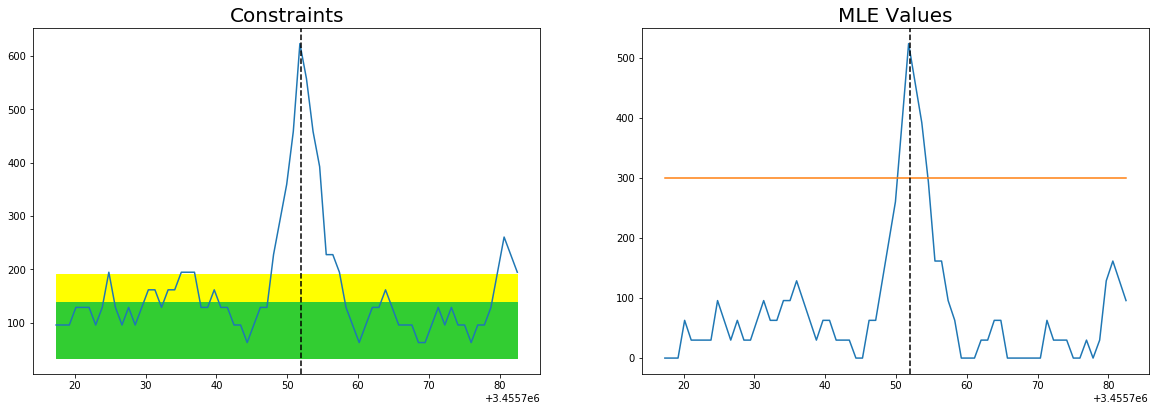

In [7]:
plt.subplot(2, 2, 1)
plt.title('Limits', size = 20)
plt.plot(mass_TestSet, A_Limits)
plt.fill_between(mass_TestSet, au.zScore(-1)*Sigma_A, au.zScore(2)*Sigma_A, color = 'yellow')
plt.fill_between(mass_TestSet, au.zScore(-1)*Sigma_A, au.zScore(1)*Sigma_A, color = 'limegreen')
plt.axvline(x=ma, ls = '--', c = 'black')


plt.subplot(2, 2, 2)
plt.title('MLE Values', size = 20)
plt.plot(mass_TestSet, A_Scans)
plt.plot(mass_TestSet, detection_Threshold)
plt.axvline(x=ma, ls = '--', c = 'black')
plt.show()

# Step 3: The MultiNest Scan

Now that we have discovered a well-localized axion signal, we proceed to perform a MultiNest Scan over the data stacked at the level of a day. This will allow us to perform more detailed analysis of the signal parameters. For example, a MultiNest scan could be used to gain a more accurate estimate of `A` or `ma`, to study the annual modulation parameters, or to search for substructure. With sufficient computational resources, these could all be accomplished simultaneously. 

In the example below, we will perform a very basic MultiNest scan to gain a more accurate estimate of the `A` parameter under the assumption that all other signal parameters are known with perfect accuracy.

In [7]:
# Basic Settings
nlive = 500
chains_dir = '/nfs/turbo/bsafdi/fosterjw/github/AxiScan/examples/chains/'

pymultinest_options = {'importance_nested_sampling': False,
                        'resume': False, 'verbose': True,
                        'sampling_efficiency': 'model',
                        'init_MPI': False, 'evidence_tolerance': 0.5,
                        'const_efficiency_mode': False}


# Parameters to Scan Over
A_Prior = [.5*np.amax(A_Scans), 2*np.amax(A_Scans)]

# Formatting the prior cube as required by MultiNest
theta_min = [A_Prior[0]]
theta_max = [A_Prior[1]]

theta_interval = list(np.array(theta_max) - np.array(theta_min))
n_params = len(theta_min) # number of parameters to fit for

def prior_cube(cube, ndim=1, nparams=1):
    """ Cube of priors - in the format required by MultiNest
    """

    for i in range(ndim):
        cube[i] = cube[i] * theta_interval[i] + theta_min[i]
    return cube

# Defining the likelihood function in terms of fixed and floated parameters
def LL_Multinest(theta, ndim = 1, nparams = 1):
    return scan.SHM_AnnualMod_ll(freqs, PSD_Data, ma, theta[0], v0_Halo, vDotMag_Halo,
                                 alpha_Halo, tbar_Halo, PSDback, stacked_per_day)

NameError: name 'np' is not defined

In [9]:
# Run the MultiNest Scan
pymultinest.run(LL_Multinest, prior_cube, n_params,
                outputfiles_basename=chains_dir,
                n_live_points=nlive, **pymultinest_options)

In [8]:
# Plot the posteriors found by the MultiNest Scan
chain_file = '/nfs/turbo/bsafdi/fosterjw/github/AxiScan/examples/chains/post_equal_weights.dat'
chain = np.array(np.loadtxt(chain_file))[:, :-1]
# Now make a triangle plot using corner
corner.corner(chain, smooth=1.5, 
              labels = ['$A$', 'frac_Sub'], truths = [A, frac_Sub],
              smooth1d=1, quantiles=[0.16, 0.5, 0.84], show_titles=True,
              title_fmt='.2f', title_args={'fontsize': 14},
              range=[1 for _ in range(chain.shape[1])],
              plot_datapoints=False, verbose=False)

plt.show()

NameError: name 'np' is not defined